In [8]:
# Requires the latest pip
!pip install --upgrade pip
# Current stable release for tf GPU
!pip install tensorflow
# install tensorflow hub
!pip install mtcnn

Requirement already up-to-date: pip in /opt/anaconda3/lib/python3.7/site-packages (20.0.2)
Requirement already up-to-date: tensorflow-hub in /opt/anaconda3/lib/python3.7/site-packages (0.8.0)


In [72]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy.ndimage import rotate
from scipy.ndimage import gaussian_filter
from math import sin,cos,pi
from skimage import exposure
import tensorflow_hub as hub
from PIL import Image
from mtcnn import MTCNN
# Set seed
np.random.seed(533)
#from keras.backend.tensorflow_backend import set_session
import sys, time, os, warnings, cv2, gc
from tensorflow import keras
from tensorflow.keras import models, callbacks
from tensorflow.keras import Sequential, Model
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, InputLayer, Input, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Embedding
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from IPython.display import SVG

# Make sure tf > 2.0
print("python {}".format(sys.version))
print("tensorflow version {}".format(tf.__version__))

python 3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
tensorflow version 2.1.0


In [73]:
# set global mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


In [3]:
# data locations
FTRAIN = '../data/training.csv'
FTEST = '../data/test.csv'
FLOOKUP = '../data/IdLookupTable.csv'

### Helper functions

In [4]:
# Function to load the dataset into numpy arrays
def load_dataset(test = False, drop_bad_data = True):
    filename = FTEST if test else FTRAIN
    print("Loading Data...")
    # Read the data into a pandas dataframe
    df = pd.read_csv(os.path.expanduser(filename))
    # 'Image' column has pixel values for input images separated by space which will be 
    # converted to numpy arrays
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    if not test:
        # Apply only on train data
        # Drop any bad data
        if drop_bad_data:
            bad_image_indices = [1747, 1877, 1907, 2199]
            cnt = 0
            for index in bad_image_indices:
                df = df.drop(df.index[index - 1 - cnt])
                cnt += 1
            # Drop rows with missing data
            df = df.dropna()
    # Scale the pixel values to be between 0, 1
    X = np.vstack(df['Image'].values) / 255.
    if not test:
        # Apply only on train data
        # Extract the labels(x, y coordinates of facial key points) from train data
        y = df[df.columns[:-1]].values
        # data with missing labels will be removed from train data
        X = X[~ np.isnan(y).any(axis=1)]
        y = y[~ np.isnan(y).any(axis=1)]
        X, y = shuffle(X, y, random_state=42)
        y = y.astype(np.float32)
    else:
        y = None 
    X = X.reshape(-1, 96, 96, 1)
    X = X.astype(np.float32)
    # Return the train/test data and labels(only for train data)
    return X, y

# function to reshape data
#def load_dataset_2d(test = False):
#    X, y = load_dataset(test = test)
#    X = X.reshape(-1, 96, 96, 1)
    
#    return X, y

# function to split given kaggle train data into train and dev datasets for further work
def split_data(X, y):
    X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
    return  X_train, X_dev, Y_train, Y_dev

# function to plot an image
def plot_image(x, y, axis):
    # Reshape input into a matrix of pixels
    img = x.reshape(96, 96)
    # Plot the pixels on gray scale
    axis.imshow(img, cmap = 'gray')
    # Mark the x and y co-ordinates with 'x' in red color
    # Rescale the co-ordinates for display
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=20, c='red')

# function to plot an image
def plot_image_2(image, y, axis):
    # Reshape input into a matrix of pixels
    #img = x.reshape(96, 96)
    #img = x
    # Plot the pixels on gray scale
    axis.imshow(image, cmap = 'gray')
    # Mark the x and y co-ordinates with 'x' in red color
    # Rescale the co-ordinates for display
    axis.scatter(y[0::2], y[1::2], marker='x', s=20, c='red')

# function to plot an image with train and predicted keypoints
def plot_predict(x, y, y_predict, axis):
    # Reshape input into a matrix of pixels
    img = x.reshape(96, 96)
    # Plot the pixels on gray scale
    axis.imshow(img, cmap = 'gray')
    # Mark the x and y co-ordinates with 'x' in red color
    # Rescale the co-ordinates for display
    axis.scatter(y[0::2], y[1::2], marker='o', s=20, c='red')
    axis.scatter(y_predict[0::2], y_predict[1::2], marker='o', s=20, c='yellow')
    
# function to get original kaggle train data
def get_orig_train_data():
    # Get the location of the train dataset
    fname = FTRAIN
    print("Loading data...")
    # Read data into pandas dataframe
    df = pd.read_csv(os.path.expanduser(fname))  # load pandas dataframe
    # 'Image' column has pixel values for input images separated by space which will be 
    # converted to numpy arrays 
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    # Scale the pixel values to be between 0, 1
    X = np.vstack(df['Image'].values) / 255.  
    X = X.astype(np.float32)
    # Extract the labels(x, y coordinates of facial key points) from train data
    y = df[df.columns[:-1]].values
    # Scale the labels which are x,y coordinates of the facial key points to be between -1 and 1
    y = (y - 48) / 48  # scale target coordinates to [-1, 1]
    # Reshape the images
    X = X.reshape(-1, 1, 96, 96)
    return X, y  

# Function to plot predictions and generate kaggle submission file
def test_predict(model, model_name, keypoints = []):
    # Load the test dataset
    #print("Loading dataset..")
    #train = pd.read_csv(os.path.expanduser(FTRAIN))
    #test = pd.read_csv(os.path.expanduser(FTEST))
    # Load the lookup file
    #lookup = pd.read_csv(os.path.expanduser(FLOOKUP))
    #X_test, _ = load_dataset(test = True)
    #X_test = np.array(image, dtype = 'float').reshape(-1,96,96,1)
    # split out image values from Kaggle test data
    image = []
    for i in range(test.shape[0]):
        img = test['Image'][i].split(' ')
        img = ['0' if j == '' else j for j in img]
        image.append(img)
    # Reshape for prediction
    X_test = np.array(image, dtype = 'float').reshape(-1,96,96,1)
    X_test.shape
    # predict on test data
    Y_test = model.predict(X_test)
    # Plot - Test Later
    #fig = plt.figure(figsize=(20, 20))
    #fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
   # for i in range(16):
   #     ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    #    img = X_test[i].reshape(96, 96)
    #    ax.imshow(img, cmap='gray')
    #    ax.scatter(Y_test[i, keypoints], Y_test[i, keypoints], marker='o', color = 'red', s=50, label = 'predict')
    return Y_test

def pipeline_test_predict(model, model_name, keypoints = []):
    images = []
    label_conv_ = []
    for i in range(test.shape[0]):
        img = test['Image'][i].split(' ')
        img = ['0' if j == '' else j for j in img]
        bounds, keypoints = detect_face_box(img)
        if bounds != False:  
            if bounds[0] < 0:
                bounds[2] += bounds[0]
                bounds[0] = 0
            if bounds[1] < 0:
                bounds[3] += bounds[1]
                bounds[1] = 0
            if bounds[0] + bounds[2] > 96:
                bounds[2] = 96 - bounds[0]
            if bounds[1] + bounds[3] > 96:
                bounds[3] = 96 - bounds[1]
            # crop image with resulting bounds
            img = img.reshape(96,96)[bounds[1]:bounds[1]+bounds[3], bounds[0]:bounds[0]+bounds[2]]
            # resize cropped image to 96x96
            img = cv2.resize(img, (96,96)).flatten()
            # find scale ratio
            Rx, Ry = 96/bounds[2], 96/bounds[3]
            label_conv_.append([bounds[0], bounds[1], Rx, Ry])
            images.append(img)
        else:
            label_conv_.append([])
            images.append(img)
    # Reshape for prediction
    X_test = np.array(images, dtype = 'float').reshape(-1,96,96,1)
    X_test.shape
    # predict on test data
    Y_test = model.predict(X_test)
    for i, conv in enumerate(label_conv_):
        if conv != []:
            Y_test[i] = [y/conv[2]+conv[0] if i%2 == 0 else y/conv[3]+conv[1] for i, y in Y_test[i]]
    return Y_test

def generate_submission(Y_test, model_name):
    # Generate submission file
    sub1_df = pd.DataFrame(Y_test, columns=train.columns[:-1])
    sub2_df = pd.concat([test['ImageId'], sub1_df], axis=1)
    sub3_df = pd.melt(sub2_df, id_vars=['ImageId'], value_vars=train.columns[:-1]).rename \
            (columns={"variable": "FeatureName", "value": "Location"})
    sub4_df = pd.merge(lookup.drop(columns=['Location']), sub3_df, on=['ImageId','FeatureName'], how='left')
    sub_final_df = sub4_df[['RowId', 'Location']]
    print(sub_final_df.shape)
    sub_final_df.head()
    # Save the file
    sub_final_df.to_csv(model_name+'.csv', index=False)

### Load the train data

In [7]:
# Load given train data without pre-processing
train_data_orig = pd.read_csv(FTRAIN)

#### Dataset 1
* left_eye_center
* right_eye_center
* node_tip
* mouth_center_bottom_lip

We will have 7000 images with 8 keypoint labels as shown below after trimming out missing data.

In [8]:
# Define the label indices for Dataset #1
d1_label_indices = [0, 1, 2, 3, 20, 21, 28, 29]
d1 = train_data_orig.iloc[:, d1_label_indices]
print(d1.shape)

# trim any missing data
d1_trim = d1[~np.isnan(d1).any(axis = 1)]
print("After trimming missing data: {}".format(d1_trim.shape))

(7049, 8)
After trimming missing data: (7000, 8)


#### Dataset #2
* left_eye_inner_corner
* left_eye_outer_corner
* right_eye_inner_corner
* right_eye_outer_corner
* left_eyebrow_inner_end
* left_eyebrow_outer_end
* right_eyebrow_inner_end
* right_eyebrow_outer_end
* mouth_left_corner
* mouth_right_corner
* mouth_center_top_lip

We will have 2155 images with 22 keypoint labels as shown below after trimming out missing data.

In [9]:
d2_label_indices = list(range(4, 20)) + list(range(22, 28))
d2 = train_data_orig.iloc[:, d2_label_indices]
print(d2.shape)

# trim any missing values
d2_trim = d2[~np.isnan(d2).any(axis = 1)]
print("After trimming missing data: {}".format(d2_trim.shape))

(7049, 22)
After trimming missing data: (2155, 22)


In [10]:
# Now split the Kaggle training dataset into input images and keypoints labels
# First shuffle the Kaggle training data
np.random.seed(533)
shuffle = np.random.permutation(np.arange(train_data_orig.shape[0]))
train_shuff = train_data_orig.iloc[shuffle].reset_index(drop=True)

print("Loading data...")
# Split out image values
images = []
for i in range(train_shuff.shape[0]):
    img = train_shuff['Image'][i].split(' ')
    img = ['0' if j == '' else j for j in img]
    images.append(img) 

# Assign to np array
X_train_orig = np.array(images, dtype = 'float32')
print(X_train_orig.shape)

# Get the keypoint labels
labels = train_shuff.drop('Image', axis = 1)
Y_train_orig = np.array(labels, dtype = 'float32')
print(Y_train_orig.shape)

Loading data...
(7049, 9216)
(7049, 30)


In [11]:
# Dataset 1

# Filter the master dataset based on labels for only 8 keypoints as defined above
keypoints = [0, 1, 2, 3, 20, 21, 28, 29]
Y_train_d1 = Y_train_orig[:, keypoints]

# Remove missing labels
# Get list of non-missing labels
index_list = ~np.isnan(Y_train_d1).any(axis=1)

# Now define the final input images and keypoint labels for Dataset1
X_train_d1 = X_train_orig[index_list]
Y_train_d1 = Y_train_d1[index_list]

print(X_train_d1.shape)
print(Y_train_d1.shape)

(7000, 9216)
(7000, 8)


In [12]:
# Filter the master dataset based on labels for only 22 keypoints as defined above
keypoints = list(range(4, 20)) + list(range(22, 28))
Y_train_d2 = Y_train_orig[:, keypoints]

# Remove missing labels
# Get list of non-missing labels
index_list = ~np.isnan(Y_train_d2).any(axis=1)

# Now define the final input images and keypoint labels for Dataset1
X_train_d2 = X_train_orig[index_list]
Y_train_d2 = Y_train_d2[index_list]

print(X_train_d2.shape)
print(Y_train_d2.shape)

(2155, 9216)
(2155, 22)


In [22]:
Y_train_d1[0]

array([67.1152, 38.2316, 30.864 , 43.1408, 47.4792, 59.0006, 48.2344,
       72.595 ], dtype=float32)

### Data Augmentation

##### Mirroring

In [ ]:
# Function to flip only the image horizontally
def flip_images(images):
    # Flip the image horizontally by inverting the pixels
    return images.reshape(-1,96,96)[:, :, list(range(95, -1, -1))].reshape(-1, 96*96)

# Function to flip the keypoint coordinates
# eg. left_eye_center_x with index 0 will be swapped with right_eye_center_x with index 2 
# Note: Only 'x' co-ordinates will be swapped. 'y' co-ordinate will be same as we are doing horizontal flip.
def flip_keypoints(keypoints, n_points):
    keypoints_flip = keypoints.copy()
    # x-coordinate flip is just 96-x. y-coordinate remains the same
    keypoints_flip[:, list(range(0, n_points-1, 2))] = 95 - keypoints[:, list(range(0, n_points-1, 2))]
    return keypoints_flip

In [ ]:
# Call function to apply flipping on train data
X_train_flip_d1 = flip_images(X_train_d1)
Y_train_flip_d1 = flip_keypoints(Y_train_d1, 8)
X_train_flip_d2 = flip_images(X_train_d2)
Y_train_flip_d2 = flip_keypoints(Y_train_d2, 22)

##### Rotation

In [ ]:
# Based on the index of the image in the dataset, the direction of degree of rotation will be done.
# For even numbered indices, the images and keypoints will use +degree rotation.
# For odd numbered indices, the images and keypoints will use -degree rotation.
# This way the augmented dataset will have images rotated in both directions.

# Rotate images at given 'degree' angle
def rotate_images(images, degree):
    # create an array for rotated images
    rotated_images = np.zeros((images.shape), dtype=np.float32)
    # For each image rotate at angle of given degree 
    # Need to keep the limit between the pixel limits
    for i in range(rotated_images.shape[0]):
        if i%2 == 0:
            angle = degree
        else:
            angle = -degree
        rotated_images[i] = np.clip(rotate(images[i], angle, reshape=False, mode='constant', cval=150), 0, 1)  
    return rotated_images
        
    
# Rotate the facial keypoint coordinates at given degree angle
def rotate_keypoints(keypoints, degree, n_points):
    # create an array for rotated keypoint coordinates
    rotated_keypoints = np.zeros((keypoints.shape), dtype=np.float32)
    # define rotation angle and center of rotation
    #theta = np.radians(degree)
    center_x = 95/2
    center_y = 95/2
    # Loop through each keypoint and do rotation
    for i in range(rotated_keypoints.shape[0]):
        if i%2 == 0:
            theta = np.radians(degree)
        else:
            theta = np.radians(-degree)
        # obtain x and y coordinates from dataset
        x = keypoints[i][np.arange(0, n_points-1, 2)]
        y = keypoints[i][np.arange(1, n_points, 2)]
        # use rotation matrix to rotate coordinates around center
        new_x = np.cos(theta) * (x - center_x) + np.sin(theta) * (y - center_y) + center_x
        new_y = -np.sin(theta) * (x - center_x) + np.cos(theta) * (y - center_y) + center_y
        # put x and y back in original shape
        rotated_keypoints[i] = np.vstack((new_x, new_y)).transpose().flatten()
    return rotated_keypoints

In [ ]:
# Call functions to rotate image and keypoints at given degree
degree = 10
X_train_rotate_d1 = rotate_images(X_train_d1, degree)
y_train_rotate_d1 = rotate_keypoints(Y_train_d1, degree, 8)
X_train_rotate_d2 = rotate_images(X_train_d2, degree)
y_train_rotate_d2 = rotate_keypoints(Y_train_d2, degree, 22)

##### Histogram Equalization

In [74]:
# Make a copy of the training dataset to apply transformation
X_hist_d1 = X_train_d1.copy()
X_hist_d2 = X_train_d2.copy()
# Apply Histogram Equalization to the images
def image_histogram_eq(X_input):
    orig_images = X_input.reshape(96, 96)
    hist_eq_images = exposure.equalize_hist(orig_images)
    return hist_eq_images

# Apply histogram equalization on original train data
for index in range(len(X_train_d1)):
    X_hist_d1[index] = image_histogram_eq(X_train_d1[index]).reshape(96,96, 1)
for index in range(len(X_train_d2)):
    X_hist_d2[index] = image_histogram_eq(X_train_d2[index]).reshape(96,96, 1)
# skimage is not able to impirt exposure on EC2. 

NameError: name 'X_train' is not defined

##### Blurring

In [ ]:
# Apply Blurring using Gaussian Filter to the train data images
# Make a copy of the training dataset to apply transformation
X_blur_d1 = X_train_d1.copy()
X_blur_d2 = X_train_d2.copy()
# Apply Gaussian Blur to all the training data images
for index in range(len(X_train_d1)):
    X_blur_d1[index] = gaussian_filter(X_blur_d1[index], sigma = 1).reshape(96, 96, 1)
for index in range(len(X_train_d2)):
    X_blur_d2[index] = gaussian_filter(X_blur_d2[index], sigma = 1).reshape(96, 96, 1)

##### Elastic Transformation

In [81]:
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
    distored_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distored_image.reshape(image.shape)



In [107]:
et_image = elastic_transform(X_train_d2[51].reshape(96,96), 150, 8).flatten()

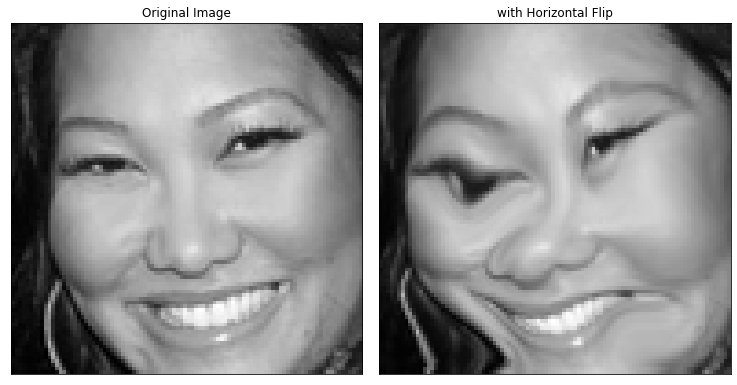

In [108]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d2[51].reshape(96,96),cmap='gray')
#ax.scatter(Y_train_d2[51, range(0, 30, 2)], Y_train_d2[51, range(1, 30, 2)], marker = 'x', s=20, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Horizontal Flip')
ax.imshow(et_image.reshape(96,96),cmap='gray')
#ax.scatter(Y_train_flip[image_index, range(0, 30, 2)], Y_train_flip[image_index, range(1, 30, 2)], marker = 'x', s=20, color='r')

plt.show()

### Face box detection

In [23]:
def detect_face_box(img):
    cv2.imwrite("../data/a.jpg", img.reshape(96,96))
    img = cv2.imread("../data/a.jpg")
    detector = MTCNN()
    result = detector.detect_faces(img)
    del img
    gc.collect()
    try:
        bounding_box = result[0]['box']
        keypoints = result[0]['keypoints']
    except Exception:
        return False, False
    return bounding_box, keypoints
#     cv2.rectangle(img,
#                   (bounding_box[0], bounding_box[1]),
#                   (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
#                   (0,155,255), 2)
#     cv2.imwrite("../data/"+str(i)+".jpg", img)


#### Test

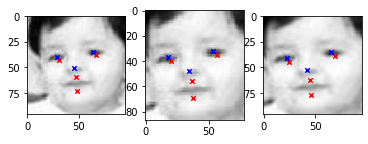

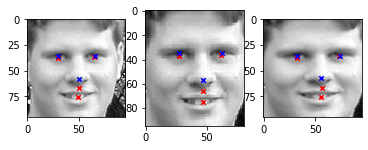

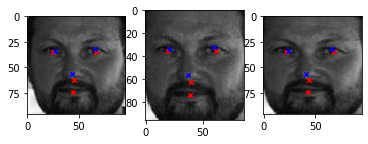

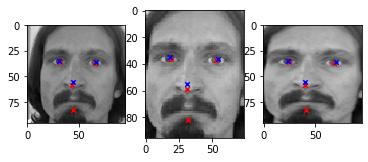

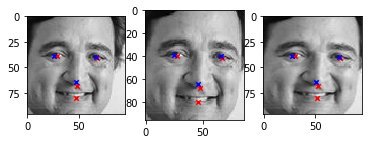

In [67]:
# fbox_x, fbox_y, fbox_w, fbox_h, nose_x, nose_y, mouth_left_x, mouth_right
X_d1 = []
Y_d1 = []
deletion = []
for i in range(5): # X_train_d1.shape[0]):
    bounds, keypoints = detect_face_box(X_train_d1[i])
    if bounds != False:
        if bounds[0] < 0:
            bounds[2] += bounds[0]
            bounds[0] = 0
        if bounds[1] < 0:
            bounds[3] += bounds[1]
            bounds[1] = 0
        if bounds[0] + bounds[2] > 96:
            bounds[2] = 96 - bounds[0]
        if bounds[1] + bounds[3] > 96:
            bounds[3] = 96 - bounds[1]
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        ax1.imshow(X_train_d1[i].reshape(96,96), cmap = 'gray')
        ax1.scatter(Y_train_d1[i][0::2], Y_train_d1[i][1::2], marker='x', s=20, c='red')
        ax1.scatter(keypoints['nose'][0], keypoints['nose'][1], marker='x', s=20, c='blue')
        ax1.scatter(keypoints['right_eye'][0], keypoints['right_eye'][1], marker='x', s=20, c='blue')
        ax1.scatter(keypoints['left_eye'][0], keypoints['left_eye'][1], marker='x', s=20, c='blue')
        # crop image with resulting bounds
        img = X_train_d1[i].reshape(96,96)[bounds[1]:bounds[1]+bounds[3], bounds[0]:bounds[0]+bounds[2]]
        ax2.imshow(img, cmap = 'gray')
        
        y = [v - bounds[0] if i%2 == 0 else v - bounds[1] for i, v in enumerate(Y_train_d1[i])]
        ax2.scatter(y[0::2], y[1::2], marker='x', s=20, c='red')
        ax2.scatter(keypoints['nose'][0] - bounds[0], keypoints['nose'][1] - bounds[1], marker='x', s=20, c='blue')
        ax2.scatter(keypoints['right_eye'][0] - bounds[0], keypoints['right_eye'][1] - bounds[1], marker='x', s=20, c='blue')
        ax2.scatter(keypoints['left_eye'][0] - bounds[0], keypoints['left_eye'][1] - bounds[1], marker='x', s=20, c='blue')
        # resize cropped image to 96x96
        img = cv2.resize(img, (96,96))
        X_d1.append(img)
        # find new x,y coord in Y_train
        Rx, Ry = 96/bounds[2], 96/bounds[3]
        y = [v * Rx if i%2 == 0 else v * Ry for i, v in enumerate(y)]
        Y_d1.append(y)
        ax3.imshow(img, cmap = 'gray')
        ax3.scatter(y[0::2], y[1::2], marker='x', s=20, c='red')
        ax3.scatter((keypoints['nose'][0] - bounds[0])*Rx, (keypoints['nose'][1] - bounds[1])*Ry, marker='x', s=20, c='blue')
        ax3.scatter((keypoints['right_eye'][0] - bounds[0])*Rx, (keypoints['right_eye'][1] - bounds[1])*Ry, marker='x', s=20, c='blue')
        ax3.scatter((keypoints['left_eye'][0] - bounds[0])*Rx, (keypoints['left_eye'][1] - bounds[1])*Ry, marker='x', s=20, c='blue')



#### Apply MTCNN on datasets

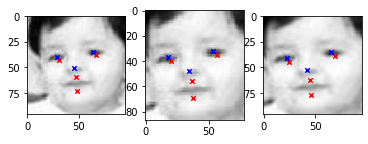

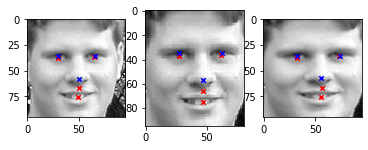

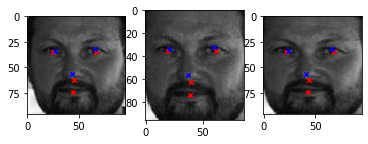

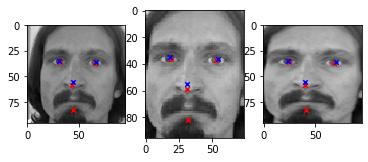

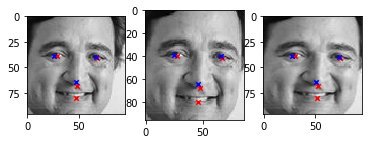

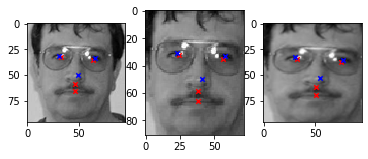

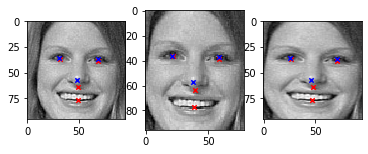

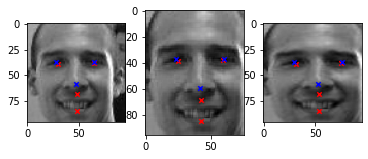

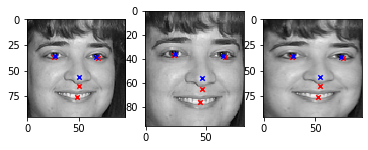

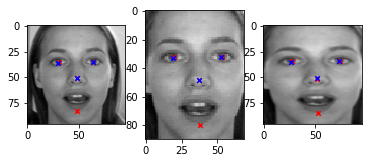

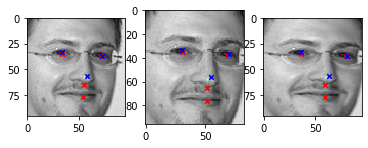

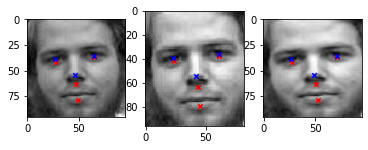

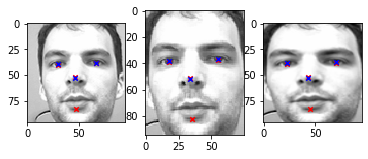

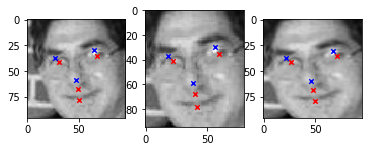

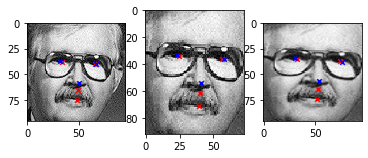

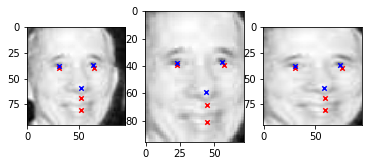

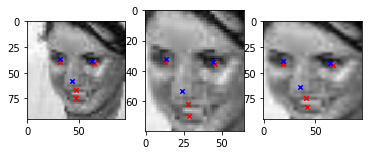

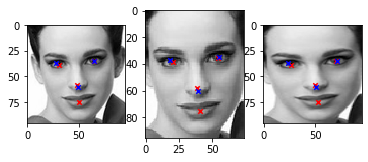

In [69]:
def zoom2facebox(data, labels, nose_kp=False):
    X_, Y_ = [], []
    label_conv_ = []
    for i in range(data.shape[0]):
        bounds, keypoints = detect_face_box(data[i])
        if bounds != False:
            if bounds[0] < 0:
                bounds[2] += bounds[0]
                bounds[0] = 0
            if bounds[1] < 0:
                bounds[3] += bounds[1]
                bounds[1] = 0
            if bounds[0] + bounds[2] > 96:
                bounds[2] = 96 - bounds[0]
            if bounds[1] + bounds[3] > 96:
                bounds[3] = 96 - bounds[1]
            # crop image with resulting bounds
            img = data[i].reshape(96,96)[bounds[1]:bounds[1]+bounds[3], bounds[0]:bounds[0]+bounds[2]]
            # resize cropped image to 96x96
            img = cv2.resize(img, (96,96)).flatten()
            # find new x,y coord in Y_train
            Rx, Ry = 96/bounds[2], 96/bounds[3]
            y = [(v - bounds[0]) * Rx if i%2 == 0 else (v - bounds[1]) * Ry for i, v in enumerate(labels[i])]
            # skip img if keypoint not in new bound
            if any([False if c > 0 and c < 96 else True for c in y]):
                continue
            label_conv_.append([bounds[0], bounds[1], Rx, Ry])
            X_.append(img)
            if nose_kp:
                y[4] = (keypoints['nose'][0] - bounds[0])*Rx
                y[5] = (keypoints['nose'][1] - bounds[1])*Ry
            Y_.append(y)
            return X_, Y_, label_conv_

# predict with mtcnn on orig data
X_train_zd1, Y_train_zd1, conv_zd1 = zoom2facebox(X_train_d1, Y_train_d1, nose_kp=True)
X_train_zd2, Y_train_zd2, conv_zd2 = zoom2facebox(X_train_d2, Y_train_d2)
# predict with mtcnn on augmented data
X_train_fd1, Y_train_fd1, conv_fd1 = zoom2facebox(X_train_flip_d1, Y_train_flip_d1, nose_kp=True)
X_train_fd2, Y_train_fd2, conv_fd2 = zoom2facebox(X_train_flip_d2, Y_train_flip_d2)
X_train_rd1, Y_train_rd1, conv_rd1 = zoom2facebox(X_train_rotate_d1, Y_train_rotate_d1, nose_kp=True)
X_train_rd2, Y_train_rd2, conv_rd2 = zoom2facebox(X_train_rotate_d1, Y_train_rotate_d1)
X_train_hd1, Y_train_hd1, conv_hd1 = zoom2facebox(X_hist_d1, Y_train_d1, nose_kp=True)
X_train_hd2, Y_train_hd2, conv_hd2 = zoom2facebox(X_hist_d2, Y_train_d2)
X_train_bd1, Y_train_bd1, conv_bd1 = zoom2facebox(X_blur_d1, Y_train_d1, nose_kp=True)
X_train_bd2, Y_train_bd2, conv_bd2 = zoom2facebox(X_blur_d2, Y_train_d2)

# combine prediction result into one master array
X_train_d1_master = np.concatenate([X_train_zd1, X_train_fd1, X_train_rd1, X_train_hd1, X_train_bd1], axis=0)
Y_train_d1_master = np.concatenate([Y_train_zd1, Y_train_fd1, Y_train_rd1, Y_train_hd1, Y_train_bd1], axis=0)
conv_d1_master = np.concatenate([conv_zd1, conv_fd1, conv_rd1, conv_hd1, conv_bd1], axis=0)

X_train_d2_master = np.concatenate([X_train_zd2, X_train_fd2, X_train_rd2, X_train_hd2, X_train_bd2], axis=0)
Y_train_d2_master = np.concatenate([Y_train_zd2, Y_train_fd2, Y_train_rd2, Y_train_hd2, Y_train_bd2], axis=0)
conv_d2_master = np.concatenate([conv_zd2, conv_fd2, conv_rd2, conv_hd2, conv_bd2], axis=0)

### Feed to VGG-16

In [ ]:
### VGG with reduced convolution layers
# Function to define the model.
# points -> indices of the keypoints to predict. 8 for dataset 1 and 22 for dataset 2
def VGG_16_2(points):
    model = Sequential()
    mohadel.add(ZeroPadding2D((1,1),input_shape=(96,96,1), data_format='channels_last'))
    model.add(Conv2D(64, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Conv2D(728, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(256, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Conv2D(512, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(1024, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='linear'))
    model.add(Dropout(0.5))
    model.add(Dense(points))

    return model

In [ ]:
# Create model using dataset 1 - 8 keypoints 
model_vgg_2_d1 = VGG_16_2(8)
model_vgg_2_d1.summary()

model_vgg_2_d1.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = [rmse])
# fit model
%time history_vgg_2_d1 = model_vgg_2_d1.fit(X_train_d1_master.reshape(-1, 96, 96, 1), Y_train_d1_master, epochs=50, \
                                 shuffle=True, batch_size=10, \
                                 validation_split = 0.2, \
                                 callbacks=[early_stop], verbose=2)

In [ ]:
# plot metrics
plt.plot(history_vgg_2_d1.history['rmse'], label = 'Train')
plt.plot(history_vgg_2_d1.history['val_rmse'], label = 'Dev')
plt.legend(loc="best")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('VGG-16_2 d1')
plt.show()

# look at final RMSE value after 10 epochs
print('Val RMSE: {}'.format(history_vgg_2_d1.history.get('val_rmse')[-1]))
print('Train RMSE: {} '.format(history_vgg_2_d1.history.get('rmse')[-1]))

In [ ]:
# Create model using dataset 2 - 22 keypoints 
model_vgg_2_d2 = VGG_16_2(22)

model_vgg_2_d2.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = [rmse])

# fit model
%time history_vgg_2_d2 = model_vgg_2_d2.fit(X_train_d2_master.reshape(-1, 96, 96, 1), Y_train_d2_master, epochs=50, \
                                 shuffle=True, batch_size=10, \
                                 validation_split = 0.2, \
                                 callbacks=[early_stop], verbose=2)

In [ ]:
# plot metrics
plt.plot(history_vgg_2_d2.history['rmse'], label = 'Train')
plt.plot(history_vgg_2_d2.history['val_rmse'], label = 'Dev')
plt.legend(loc="best")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('VGG-16_2 d2')
plt.show()

# look at final RMSE value after 10 epochs
print('Val RMSE: {}'.format(history_vgg_2_d2.history.get('val_rmse')[-1]))
print('Train RMSE: {} '.format(history_vgg_2_d2.history.get('rmse')[-1]))

In [ ]:
# Using the 2 trained models predict on Test data
Y_test_vgg_2_d1 = pipeline_test_predict(model_vgg_2_d1, 'vgg_2_d1')
Y_test_vgg_2_d2 = pipeline_test_predict(model_vgg_2_d2, 'vgg_2_d2')

# Combine both results
Y_test_vgg_2_combined = np.zeros((1783, 30), dtype = np.float32)
Y_test_vgg_2_combined[:, d1_label_indices] = Y_test_vgg_2_d1
Y_test_vgg_2_combined[:, d2_label_indices] = Y_test_vgg_2_d2

In [ ]:
# Call function to generate kaggle submission file for scoring   
generate_submission(Y_test_vgg_2_combined, 'vgg16_2_split_data')